## Analyzing the Regional GTFS data

In [18]:
#loading required libraries

import sys
from pathlib import Path
import json

import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib

import gtfs_kit as gk

import os
import zipfile

import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [19]:
#setting GTFS data directory path for loading
DIR = Path('..')
sys.path.append(str(DIR))
DATA_DIR = DIR/'gtfs_data/' #GTFS datasets to be processed must be downloaded or stored here.

#loading GTFS data and list the feed components. You may edit the path variable depending upon where the GTFS dataset is stored.
path = DATA_DIR/'gtfs-openov-nl.zip'
gk.list_feed(path)

#Setting GTFS data details. REGION_NAME attribute is the region covered by the available GTFS dataset. For the openov dataset, it is the Netherlands.
#CITY_NAME is the city of interest. The city must be a subset of the GTFS region. Use the name attribute from the OSM Hague page (https://www.openstreetmap.org/relation/192737)
REGION_NAME = 'netherlands'
CITY_NAME = 'Rotterdam' 

In [9]:
#Describe feed details

feed = gk.read_feed(path, dist_units='km')
feed.describe()

,indicator,value
0,agencies,"[allGo (Keolis), Arriva, Bravo (Arriva), Bravo..."
1,timezone,Europe/Amsterdam
2,start_date,20201217
3,end_date,20210808
4,num_routes,2493
5,num_trips,930228
6,num_stops,46611
7,num_shapes,9155
8,sample_date,20201224
9,num_routes_active_on_sample_date,1974


In [10]:
#Idenitfy the inconsistencies with the data
feed.validate()

,type,message,table,rows
0,warning,Unrecognized column feed_id,feed_info,[]
1,warning,"Repeated pair (route_short_name, route_long_name)",routes,"[367, 368, 372, 505, 507, 517, 896, 1024, 1070..."
4,warning,Unrecognized column fare_units_traveled,stop_times,[]
5,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[8974288, 4752998, 2651246, 561910, 4752999, 1..."
2,warning,Unrecognized column platform_code,stops,[]
3,warning,Stop has no stop times,stops,"[72, 6420, 10560, 11353, 11355, 11360, 11411, ..."
6,warning,Unrecognized column realtime_trip_id,trips,[]
7,warning,Unrecognized column trip_long_name,trips,[]


## Plotting the GTFS data

In [19]:
#Decompressing the zipped GTFS dataset to individual files. Refer to https://developers.google.com/transit/gtfs for information regarding the GTFS constituent files and attributes.
with zipfile.ZipFile(path, 'r') as file:
    file.extractall(DIR/'gtfs_data/{}/'.format(REGION_NAME))

#List constituent files from the GTFS dataset
os.listdir(DIR/'gtfs_data/{}/'.format(REGION_NAME))

['agency.txt',
 'calendar_dates.txt',
 'feed_info.txt',
 'routes.txt',
 'shapes.txt',
 'stops.txt',
 'stop_times.txt',
 'trips.txt']

In [34]:
#Loading GTFS files as pandas dataframes for viewing and anlysis
import pandas as pd

trips = pd.read_csv(DIR/'gtfs_data/{}/trips.txt'.format(REGION_NAME), low_memory=False)
shapes = pd.read_csv(DIR/'gtfs_data/{}/shapes.txt'.format(REGION_NAME), low_memory=False)
routes = pd.read_csv(DIR/'gtfs_data/{}/routes.txt'.format(REGION_NAME), low_memory=False)

In [10]:
trips.head()

,route_id,service_id,trip_id,realtime_trip_id,trip_headsign,trip_short_name,trip_long_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,60663,1,123151939,GVB:248:67,Houthavens,NaN,NaN,0,NaN,911191.0,1,NaN
1,60663,1,123151940,GVB:248:70,Houthavens,NaN,NaN,0,NaN,911191.0,1,NaN
2,60663,1,123151932,GVB:248:53,Houthavens,NaN,NaN,0,NaN,911191.0,1,NaN
3,60663,1,123151991,GVB:248:184,Centraal Station,NaN,NaN,1,NaN,911190.0,1,NaN
4,60663,1,123151909,GVB:248:6,Houthavens,NaN,NaN,0,NaN,911191.0,1,NaN


In [11]:
shapes.head()

,shape_id,shape_pt_sequence,shape_pt_lat,shape_pt_lon,shape_dist_traveled
0,899197,1,51.93779,4.33613,0
1,899197,2,51.93312,4.34160,1076
2,899197,4,51.93318,4.34167,1085
3,899197,5,51.93322,4.34171,1090
4,899197,6,51.93330,4.34192,1107


In [12]:
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,route_url
0,73358,BRENG,78,Papendal - Beekdal Lyceum,NaN,3,NaN,NaN,NaN
1,75937,ARR,2,Brunssum/Hoensbroek via Heerlen - Bleijerheide,NaN,3,NaN,NaN,NaN
2,67394,IFF:NS,Intercity,Den Haag Centraal <-> Eindhoven Centraal IC1100,NaN,2,NaN,NaN,NaN
3,67395,IFF:NS,Intercity,Nachtnettrein Rotterdam Centraal <-> Eindhoven...,NaN,2,NaN,NaN,NaN
4,67396,IFF:RNET,Stopbus i.p.v. trein,Stopbus i.p.v. trein Dordrecht <-> Geldermalsen,NaN,3,NaN,NaN,NaN


In [16]:
#List the public transit modes available in the current GTFS dataset
routes.route_type.unique().tolist()

#0 - Tram, Streetcar, Light rail. Any light rail or street level system within a metropolitan area.
#1 - Subway, Metro. Any underground rail system within a metropolitan area.
#2 - Rail. Used for intercity or long-distance travel.
#3 - Bus. Used for short- and long-distance bus routes.
#4 - Ferry. Used for short- and long-distance boat service.

# More details at https://developers.google.com/transit/gtfs/reference#tripstxt

[3, 2, 0, 1, 4]

In [28]:
num_trips_by_shape = trips.groupby('shape_id').aggregate({'route_id': 'count'}).reset_index()
num_trips_by_shape.rename({'route_id': 'trip_count'}, axis='columns', inplace=True)

shapes_with_nums = shapes.merge(num_trips_by_shape, on='shape_id')
shapes_with_nums.head()

,shape_id,shape_pt_sequence,shape_pt_lat,shape_pt_lon,shape_dist_traveled,trip_count
0,899197,1,51.93779,4.33613,0,146
1,899197,2,51.93312,4.34160,1076,146
2,899197,4,51.93318,4.34167,1085,146
3,899197,5,51.93322,4.34171,1090,146
4,899197,6,51.93330,4.34192,1107,146


In [29]:
#Plotting the GTFS data
from datashader.utils import lnglat_to_meters
import numpy as np

shapes_with_nums['coord_x'], shapes_with_nums['coord_y'] = \
    lnglat_to_meters(shapes_with_nums['shape_pt_lon'], shapes_with_nums['shape_pt_lat'])

def split_df_by(df, byvar):
    df_parts = []
    for level, df_part in df.groupby(byvar):
        empty = pd.DataFrame([[level if colname == byvar else np.NaN for colname in df.columns]],
                             columns=df.columns)
        df_parts.append(df_part.append(empty))
    return pd.concat(df_parts) 

sep_shapes = split_df_by(shapes_with_nums, 'shape_id')

In [31]:
import bokeh.plotting as bp
from bokeh.models.tiles import WMTSTileSource
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
from datashader.utils import export_image
import colorcet as cc
import os

bp.output_notebook()

x_range=(0.3e6, 1.155e6)
y_range=(4.994e6, 8.052e6)

if not os.path.exists('./img'):
    os.mkdir('./img')
p = bp.figure(tools='pan,wheel_zoom,reset',
              plot_width=int(600),
              plot_height=int(600),
              x_range=x_range,
              y_range=y_range)

p.axis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

url = "https://cartodb-basemaps-b.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png"
tile_renderer = p.add_tile(WMTSTileSource(url=url))
tile_renderer.alpha = 1

def image_callback(x_range, y_range, w, h, color_fn=tf.shade):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.line(sep_shapes, 'coord_x', 'coord_y', agg=ds.sum('trip_count'))
    image = tf.shade(agg, cmap=cc.fire, how='eq_hist')
    return image

export_image(image_callback(x_range=x_range, y_range=y_range, w=2000, h=2000),
             filename="BUD_schedule_fire", background='black')
InteractiveImage(p, image_callback)

Loading BokehJS ...

C:\Users\srijith\anaconda3\envs\geo_env\lib\site-packages\datashader\bokeh_ext.py:233: VisibleDeprecationWarning: InteractiveImage has been deprecated as of datashader 0.8.0. It is not supported in JupyterLab and Bokeh server environments. Please use the HoloViews datashader integration instead.
  warnings.warn('InteractiveImage has been deprecated as of datashader 0.8.0. '


## Filtering Public Transit Lines that are within or pass through selected city

<AxesSubplot:>

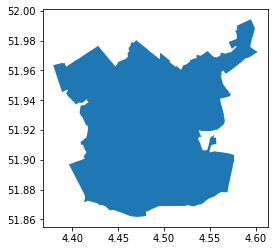

In [20]:
#Download the desired city map from Openstreetmaps. For now, we use Hague.

# define the place query.
query = {'city': CITY_NAME}

# get the boundaries of the place
gdf = ox.geocode_to_gdf(query)
gdf.plot()

In [ ]:
#Create directory for the city to store GTFS files
if not os.path.exists(DIR/'gtfs_data/cities/{}/stops.txt'.format(CITY_NAME)):
    os.makedirs(DIR/'gtfs_data/cities/{}/stops.txt'.format(CITY_NAME))

In [36]:
from shapely.geometry import Point

geom = gdf.loc[0, 'geometry']

# determine if a point is within the city boundary (example)
coords = (4.281028, 52.073533)
geom.intersects(Point(coords))

False

In [37]:
#Now we need to identify which all transit stations/stops in the GTFS datasets are located within the city's limits. For that first we load te stops.txt file from the GTFS dataset
stops = pd.read_csv(DIR/'gtfs_data/{}/stops.txt'.format(REGION_NAME), low_memory=False)

In [38]:
stops.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,stop_timezone,wheelchair_boarding,platform_code
0,1,NaN,"Arnhem, Station Presikhaaf",51.987910,5.941563,0,NaN,NaN,1.0,NaN
1,10,NaN,"Doesburg, Tunnel Angerlo",51.997992,6.129636,0,NaN,NaN,1.0,NaN
2,1004,NaN,"Warnsveld, GGNet",52.131585,6.249971,0,NaN,NaN,1.0,NaN
3,1007,NaN,"Rheden, Oranjeweg",52.002476,6.032238,0,NaN,NaN,1.0,NaN
4,1013214,NaN,"Assen, Triade",52.998037,6.558162,0,NaN,NaN,0.0,NaN


In [39]:
#filtering transit stations within Hague
subset_stations_list = []

for index, row in stops.iterrows():
    coords = (stops.stop_lon[index], stops.stop_lat[index])
    if geom.intersects(Point(coords)) == True:
        subset_stations_list.append(stops.stop_id[index]) 

In [40]:
len(subset_stations_list)

1196

In [42]:
#Creating the stops.txt file for Hague GTFS
subset_stops = stops[stops['stop_id'].isin(subset_stations_list)]
subset_stops.to_csv(DIR/'gtfs_data/cities/{}/stops.txt'.format(CITY_NAME), header=True, index=False, sep=',')
    
subset_stops = pd.read_csv(DIR/'gtfs_data/cities/{}/stops.txt'.format(CITY_NAME), sep=',')
subset_stops.tail()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,stop_timezone,wheelchair_boarding,platform_code
1191,NL:S:31008146,NaN,"Rotterdam, Delfshaven",51.910072,4.445762,1,NaN,Europe/Amsterdam,0.0,NaN
1192,NL:S:31008148,NaN,"Rotterdam, Marconiplein",51.913576,4.432259,1,NaN,Europe/Amsterdam,0.0,NaN
1193,NL:S:31008701,NaN,"Rotterdam, Meijersplein / Airport",51.956032,4.462228,1,NaN,Europe/Amsterdam,0.0,NaN
1194,NL:S:31008703,NaN,"Rotterdam, Blijdorp",51.930806,4.457847,1,NaN,Europe/Amsterdam,0.0,NaN
1195,NL:S:31008707,NaN,"Rotterdam, Melanchthonweg",51.948491,4.464572,1,NaN,Europe/Amsterdam,0.0,NaN


In [43]:
#Creating the stop_times.txt for GTFS of the new city
stop_times = pd.read_csv(DIR/'gtfs_data/{}/stop_times.txt'.format(REGION_NAME), low_memory=False)
stop_times['stop_id'] = stop_times['stop_id'].astype(str)
stop_times.head()

,trip_id,stop_sequence,stop_id,stop_headsign,arrival_time,departure_time,pickup_type,drop_off_type,timepoint,shape_dist_traveled,fare_units_traveled
0,123996698,14,2337695,NaN,20:58:03,20:58:03,0,0,0,18229.0,18229
1,123996698,3,2335278,NaN,20:35:11,20:35:11,0,0,0,847.0,847
2,123996698,1,2335260,NaN,20:34:00,20:34:00,0,1,1,0.0,0
3,123996697,14,2337695,NaN,19:58:03,19:58:03,0,0,0,18229.0,18229
4,123996697,3,2335278,NaN,19:35:11,19:35:11,0,0,0,847.0,847


In [44]:
trip_list = stop_times.trip_id.unique()
#trip_list = [125353018]
print(trip_list)
print(len(trip_list))

[123996698 123996697 122482725 ... 125587071 125587097 125587111]
930228


In [46]:
subset_trips_list = []
for index, trip in enumerate(trip_list):
    curr_service = stop_times[stop_times.trip_id == trip]
    
    if curr_service['stop_id'].isin(subset_stops.stop_id).any():
        subset_trips_list.append(trip)

    if index % 500 == 0:
        print(index, len(subset_trips_list))
    
print(len(subset_trips_list))

0 0
500 50
1000 58
1500 60
2000 79
2500 116
3000 166
3500 178
4000 192
4500 217
5000 220
5500 240
6000 241
6500 279
7000 292
7500 369
8000 392
8500 417
9000 435
9500 503
10000 511
10500 571
11000 615
11500 631
12000 679
12500 755
13000 765
13500 781
14000 847
14500 871
15000 908
15500 943
16000 945
16500 956
17000 1029
17500 1030
18000 1099
18500 1119
19000 1154
19500 1203
20000 1256
20500 1333
21000 1415
21500 1417
22000 1434
22500 1440
23000 1486
23500 1495
24000 1496
24500 1509
25000 1515
25500 1560
26000 1618
26500 1619
27000 1621
27500 1688
28000 1688
28500 1711
29000 1778
29500 1863
30000 1899
30500 1908
31000 1974
31500 2005
32000 2046
32500 2051
33000 2054
33500 2063
34000 2076
34500 2090
35000 2094
35500 2132
36000 2187
36500 2194
37000 2266
37500 2267
38000 2287
38500 2328
39000 2336
39500 2342
40000 2364
40500 2404
41000 2474
41500 2504
42000 2512
42500 2609
43000 2614
43500 2621
44000 2635
44500 2665
45000 2673
45500 2720
46000 2725
46500 2736
47000 2767
47500 2788
48000 27

In [47]:
subset_stop_times = stop_times[stop_times['trip_id'].isin(subset_trips_list)]
subset_stop_times.to_csv(DIR/'gtfs_data/cities/{}/stop_times.txt'.format(CITY_NAME), header=True, index=False, sep=',')

subset_stop_times = pd.read_csv(DIR/'gtfs_data/cities/{}/stop_times.txt'.format(CITY_NAME), sep=',')
subset_stop_times.head()

,trip_id,stop_sequence,stop_id,stop_headsign,arrival_time,departure_time,pickup_type,drop_off_type,timepoint,shape_dist_traveled,fare_units_traveled
0,118921361,47,2296068,Station Noord,17:37:37,17:37:37,1,0,0,30529.0,29549
1,118921361,38,1100763,Station Noord,17:26:42,17:26:42,0,0,0,27293.0,26387
2,118921361,37,1100766,Station Noord,17:26:02,17:26:02,0,0,0,27056.0,26157
3,118921361,35,1100764,Station Noord,17:24:22,17:24:22,0,0,0,26470.0,25584
4,118921361,34,1100760,Station Noord,17:23:01,17:23:01,0,0,0,25992.0,25116


In [48]:
#Creating trips.txt for Hague
trips = pd.read_csv(DIR/'gtfs_data/{}/trips.txt'.format(REGION_NAME), low_memory=False)

subset_trips = trips[trips['trip_id'].isin(subset_trips_list)]
subset_trips.to_csv(DIR/'gtfs_data/cities/{}/trips.txt'.format(CITY_NAME), header=True, index=False, sep=',')

subset_trips = pd.read_csv(DIR/'gtfs_data/cities/{}/trips.txt'.format(CITY_NAME), sep=',')
subset_trips.head()

,route_id,service_id,trip_id,realtime_trip_id,trip_headsign,trip_short_name,trip_long_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,32518,542,118921360,RET:601:150266,Delft via Berkel,NaN,Streekbus,0,NaN,947743.0,0,NaN
1,32518,542,118921353,RET:601:150253,Berkel Westpolder,NaN,Streekbus,0,NaN,947743.0,0,NaN
2,32518,542,118921343,RET:601:150239,Rotterdam Noord via Berkel,NaN,Streekbus,1,NaN,947744.0,0,NaN
3,75871,542,118920332,RET:15:149287,Rotterdam Centraal,NaN,Frequentbus,0,NaN,944207.0,0,NaN
4,75871,542,118920336,RET:15:149293,Rotterdam Centraal,NaN,Frequentbus,0,NaN,944207.0,0,NaN


In [49]:
#Creating trips.txt for Hague
calender_dates = pd.read_csv(DIR/'gtfs_data/{}/calendar_dates.txt'.format(REGION_NAME), low_memory=False)

subset_calendar = calender_dates[calender_dates['service_id'].isin(subset_trips.service_id)]
subset_calendar.to_csv(DIR/'gtfs_data/cities/{}/calender_dates.txt'.format(CITY_NAME), header=True, index=False, sep=',')

subset_calendar = pd.read_csv(DIR/'gtfs_data/cities/{}/calender_dates.txt'.format(CITY_NAME), sep=',')
subset_calendar.head()

,service_id,date,exception_type
0,1,20201217,1
1,2,20201217,1
2,2,20210114,1
3,2,20210121,1
4,2,20210128,1


In [50]:
#Creating routes.txt for the selected city
subset_routes_list = subset_trips.route_id.unique()
subset_routes_list[0:10]

array([32518, 75871, 32514, 32512, 75753, 32563, 32566, 73468, 59426,
       30601], dtype=int64)

In [51]:
routes = pd.read_csv(DIR/'gtfs_data/{}/routes.txt'.format(REGION_NAME), low_memory=False)
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,route_url
0,73358,BRENG,78,Papendal - Beekdal Lyceum,NaN,3,NaN,NaN,NaN
1,75937,ARR,2,Brunssum/Hoensbroek via Heerlen - Bleijerheide,NaN,3,NaN,NaN,NaN
2,67394,IFF:NS,Intercity,Den Haag Centraal <-> Eindhoven Centraal IC1100,NaN,2,NaN,NaN,NaN
3,67395,IFF:NS,Intercity,Nachtnettrein Rotterdam Centraal <-> Eindhoven...,NaN,2,NaN,NaN,NaN
4,67396,IFF:RNET,Stopbus i.p.v. trein,Stopbus i.p.v. trein Dordrecht <-> Geldermalsen,NaN,3,NaN,NaN,NaN


In [52]:
subset_routes = routes[routes['route_id'].isin(subset_routes_list)]
subset_routes.to_csv(DIR/'gtfs_data/cities/{}/routes.txt'.format(CITY_NAME), header=True, index=False, sep=',')

subset_routes = pd.read_csv(DIR/'gtfs_data/cities/{}/routes.txt'.format(CITY_NAME), sep=',')
subset_routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,route_url
0,67394,IFF:NS,Intercity,Den Haag Centraal <-> Eindhoven Centraal IC1100,NaN,2,NaN,NaN,NaN
1,67395,IFF:NS,Intercity,Nachtnettrein Rotterdam Centraal <-> Eindhoven...,NaN,2,NaN,NaN,NaN
2,67402,IFF:NS,Intercity,Nachtnettrein Utrecht Centraal <-> Rotterdam C...,NaN,2,NaN,NaN,NaN
3,74390,RET,607,Buurtbus Capelle,NaN,3,NaN,NaN,NaN
4,74389,RET,606,Buurtbus Kralingse Veer,NaN,3,NaN,NaN,NaN


In [53]:
#creating agency.txt for hague
subset_agency_list = subset_routes.agency_id.unique()
subset_agency_list[0:10]

array(['IFF:NS', 'RET', 'CXX', 'ARR', 'WATERBUS', 'QBUZZ', 'SYNTUS:UT',
       'BRAVO:ARR', 'EBS', 'IFF:NSI'], dtype=object)

In [54]:
agency = pd.read_csv(DIR/'gtfs_data/{}/agency.txt'.format(REGION_NAME), low_memory=False)
agency.head()

,agency_id,agency_name,agency_url,agency_fare_url,agency_timezone,agency_phone
0,ALLGO,allGo (Keolis),http://www.allgobus.nl,NaN,Europe/Amsterdam,003188-0331360
1,ARR,Arriva,https://www.arriva.nl,https://www.arriva.nl/eticket,Europe/Amsterdam,0031900-2022022
2,BRAVO:ARR,Bravo (Arriva),http://www.bravo.info,https://www.arriva.nl/eticket,Europe/Amsterdam,0031800-0232545
3,BRAVO:CXX,Bravo (Hermes),http://www.bravo.info,https://eticket.connexxion.nl/,Europe/Amsterdam,0031800-0222277
4,BRENG,Breng,http://www.breng.nl,NaN,Europe/Amsterdam,003126-2142140


In [55]:
subset_agency = agency[agency['agency_id'].isin(subset_agency_list)]
subset_agency.to_csv(DIR/'gtfs_data/cities/{}/agency.txt'.format(CITY_NAME), header=True, index=False, sep=',')

subset_agency = pd.read_csv(DIR/'gtfs_data/cities/{}/agency.txt'.format(CITY_NAME), sep=',')
subset_agency.head()

,agency_id,agency_name,agency_url,agency_fare_url,agency_timezone,agency_phone
0,ARR,Arriva,https://www.arriva.nl,https://www.arriva.nl/eticket,Europe/Amsterdam,0031900-2022022
1,BRAVO:ARR,Bravo (Arriva),http://www.bravo.info,https://www.arriva.nl/eticket,Europe/Amsterdam,0031800-0232545
2,CXX,Connexxion,http://www.connexxion.nl,https://eticket.connexxion.nl/,Europe/Amsterdam,0031900-2666399
3,EBS,EBS,http://www.ebs-ov.nl,NaN,Europe/Amsterdam,0031800-0327
4,IFF:NS,NS,http://www.ns.nl,http://www.ns.nl/eticket,Europe/Amsterdam,003130-7515155


In [56]:
#Creating shapes.txt for selected city
subset_shapes_list = subset_trips.shape_id.unique()
subset_shapes_list[0:10]

array([947743., 947744., 944207., 947686., 899200., 919692., 945654.,
       947682., 943343., 919757.])

In [57]:
shapes = pd.read_csv(DIR/'gtfs_data/{}/shapes.txt'.format(REGION_NAME), low_memory=False)
shapes.head()

,shape_id,shape_pt_sequence,shape_pt_lat,shape_pt_lon,shape_dist_traveled
0,899197,1,51.93779,4.33613,0
1,899197,2,51.93312,4.34160,1076
2,899197,4,51.93318,4.34167,1085
3,899197,5,51.93322,4.34171,1090
4,899197,6,51.93330,4.34192,1107


In [58]:
subset_shapes = shapes[shapes['shape_id'].isin(subset_shapes_list)]
subset_shapes.to_csv(DIR/'gtfs_data/cities/{}/shapes.txt'.format(CITY_NAME), header=True, index=False, sep=',')

subset_shapes = pd.read_csv(DIR/'gtfs_data/cities/{}/shapes.txt'.format(CITY_NAME), sep=',')
subset_shapes.head()

,shape_id,shape_pt_sequence,shape_pt_lat,shape_pt_lon,shape_dist_traveled
0,899200,1,51.91355,4.43175,0
1,899200,2,51.91366,4.43191,16
2,899200,3,51.91354,4.43208,34
3,899200,4,51.91343,4.43193,50
4,899200,5,51.91333,4.43178,65
